In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os

import math  
import sys  
sys.path.append('C:/Users/j/hotai/myfolder')

from my_function import miscore, siscore
# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

addp=5
startp=90
endp=120
dp=endp-startp
p_tot=addp*(dp-1)+1
file_tot=100
n=25
xstart=0
xend=25

In [2]:
def read_data(file_path,file_name,n,file_start=0,file_end=0,xstart=0,xend=0):
    x=np.zeros((121,n,n))
    y=np.zeros((121,n,n))
    vx=np.zeros((121,n,n))
    vy=np.zeros((121,n,n))
    for i in range(file_start,file_end):
        xp=[]
        yp=[]
        vxp=[]
        vyp=[]
        isvalid=[]
        xtmp=[]
        ytmp=[]
        vxtmp=[]
        vytmp=[]
        isvalidtmp=[]
        
        for root,dirs,files in os.walk(file_path):
            #print(root)
            
            for dir in dirs:
                #print(os.path.join(root,file))
                
    
                    with open(os.path.join(root,dir,file_name[i]), 'r') as f:  
                        lines = f.readlines()
                        for line in lines[3:]: 
                            num=line.split()
                            xtmp.append(float(num[0]))
                            ytmp.append(float(num[1]))
                            vxtmp.append(float(num[2]))
                            vytmp.append(float(num[3]))
                            isvalidtmp.append(float(num[4]))
        
                    xp.append(np.array(xtmp).reshape(25,25))
                    yp.append(np.array(ytmp).reshape(25,25))
                    vxp.append(np.array(vxtmp).reshape(25,25))
                    vyp.append(np.array(vytmp).reshape(25,25))
                    isvalid.append(np.array(isvalidtmp).reshape(25,25))
                    xtmp=[]
                    ytmp=[]
                    vxtmp=[]
                    vytmp=[]
                    isvalidtmp=[]
        #
        xp=np.array(xp)
        yp=np.array(yp)
        vxp=np.array(vxp)
        vyp=np.array(vyp)
        isvalid=np.array(isvalid)
        x=x+xp/file_tot
        y=y+yp/file_tot
        vx=vx+vxp/file_tot
        vy=vy+vyp/file_tot
    x=x.T
    x=x[xstart:xend,xstart:xend]
    y=y.T
    y=y[xstart:xend,xstart:xend]
    vx=vx.T
    vx=vx[xstart:xend,xstart:xend]
    vy=vy.T
    vy=vy[xstart:xend,xstart:xend]
    isvalid=isvalid.T
    isvalid=isvalid[xstart:xend,xstart:xend]
    return x,y,vx,vy

In [3]:
file_path = os.path.join('D:\\', 'hotaidata','sr_C4_12')
file_name=['B00001.dat','B00002.dat','B00003.dat','B00004.dat','B00005.dat','B00006.dat','B00007.dat','B00008.dat',
           'B00009.dat','B00010.dat','B00011.dat','B00012.dat','B00013.dat','B00014.dat','B00015.dat','B00016.dat','B00017.dat',
           'B00018.dat','B00019.dat','B00020.dat','B00021.dat','B00022.dat','B00023.dat','B00024.dat','B00025.dat','B00026.dat',
           'B00027.dat','B00028.dat','B00029.dat','B00030.dat','B00031.dat','B00032.dat','B00033.dat','B00034.dat','B00035.dat',
           'B00036.dat','B00037.dat','B00038.dat','B00039.dat','B00040.dat','B00041.dat','B00042.dat','B00043.dat','B00044.dat',
           'B00045.dat','B00046.dat','B00047.dat','B00048.dat','B00049.dat','B00050.dat','B00051.dat','B00052.dat','B00053.dat',
           'B00054.dat','B00055.dat','B00056.dat','B00057.dat','B00058.dat','B00059.dat','B00060.dat','B00061.dat','B00062.dat',
           'B00063.dat','B00064.dat','B00065.dat','B00066.dat','B00067.dat','B00068.dat','B00069.dat','B00070.dat','B00071.dat',
           'B00072.dat','B00073.dat','B00074.dat','B00075.dat','B00076.dat','B00077.dat','B00078.dat','B00079.dat','B00080.dat',
           'B00081.dat','B00082.dat','B00083.dat','B00084.dat','B00085.dat','B00086.dat','B00087.dat','B00088.dat','B00089.dat',
           'B00090.dat','B00091.dat','B00092.dat','B00093.dat','B00094.dat','B00095.dat','B00096.dat','B00097.dat','B00098.dat',
           'B00099.dat','B00100.dat']
x=np.zeros((121,n,n))
y=np.zeros((121,n,n))
vx=np.zeros((121,n,n))
vy=np.zeros((121,n,n))

x,y,vx,vy=read_data(file_path,file_name,25,0,50,xstart,xend)
#print(x[0,:,:])
t=np.linspace(0,60/800,121)
dt=t[1]-t[0]

t=t[startp:endp]
print(len(t))
t_train=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
dt_train=t_train[1]-t_train[0]
print(len(t_train.shape))

30
1


In [4]:
#u is not pre adding, v add a median
spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T

n=xend-xstart

t_in=np.zeros((n,n,dp))
for i in range (dp):
    t_in[:,:,i]=t[i]

print(t_in[0,0])

u=np.zeros((n,n,121, 3))

u[:, :, :, 0] = vx
u[:, :, :, 1] = vy
u[:, :, startp:endp, 2] = t_in
u_train=np.zeros((n,n,len(t), 3))
u_train=u[:,:,startp:endp,:]

v_train=np.zeros((n,n,len(t_train),3))

for i in range(len(t)-1):
    for j in range(addp):
        v_train[:,:,addp*i+j]=(u_train[:,:,i]*(addp-j)+u_train[:,:,i+1]*j)/addp
v_train[:,:,-1]=u_train[:,:,-1]


[0.05625  0.056875 0.0575   0.058125 0.05875  0.059375 0.06     0.060625
 0.06125  0.061875 0.0625   0.063125 0.06375  0.064375 0.065    0.065625
 0.06625  0.066875 0.0675   0.068125 0.06875  0.069375 0.07     0.070625
 0.07125  0.071875 0.0725   0.073125 0.07375  0.074375]


<function matplotlib.pyplot.show(close=None, block=None)>

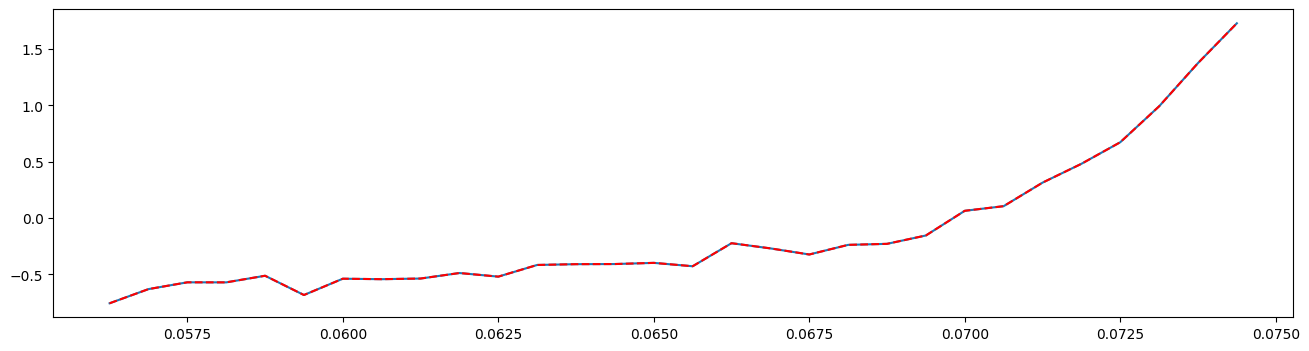

In [5]:
op=np.zeros(len(t))
op=u_train[10,10,:,0]
op_train=np.zeros(len(t_train))
for i in range(len(t)-1):
    for j in range(addp):
        op_train[i*addp+j]=(op[i]*(addp-j)+op[i+1]*j)/addp
op_train[-1]=op[-1]
plt.figure(figsize=(16, 4))
plt.plot(t,op)
plt.plot(t_train,op_train,'r--')
plt.show

In [6]:
v_train_dot = ps.FiniteDifference(axis=2)._differentiate(v_train, dt_train)

vtmp=np.zeros(v_train_dot.shape)
vtmp[:,:,0]=v_train[:,:,0]
for i in range(len(t_train)-1):
    vtmp[:,:,i+1]=vtmp[:,:,i]+v_train_dot[:,:,i]*dt_train
miscore(vtmp,v_train)
siscore(vtmp,v_train)
vtmp=v_train+v_train_dot*dt_train

vtmp[:,:,1:]=vtmp[:,:,:len(t_train)-1]
miscore(vtmp,v_train)
siscore(vtmp,v_train)


MI(average/percent):
0.993036618114086 0.999712770658418
SI(average/percent):
0.9999999999999895 1.0
MI(average/percent):
0.9984226445477818 0.9998674326115775
SI(average/percent):
0.9995628841352113 1.0


(0.9995628841352113, 1.0)

In [7]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.    periodic=True

library_functions = [
    lambda y: y,
    lambda x: x*x,
    
    lambda x, y: x * y,
    lambda x, y: x * x * y,
    lambda x , y , z: x * y * z
]
library_function_names = [
    lambda y: y,
    lambda x: x+x,
    
    lambda x, y: x + y,
    lambda x, y: x + x + y,
    lambda x , y , z: x + y + z
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=1,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True
    
)




print('SINDy')
model = ps.SINDy(feature_library=pde_lib, feature_names=['Vx','Vy','t'])

model.fit(v_train, x_dot=v_train_dot)
model.print()
#u_dot_stlsq = model.predict(v_train)x_dot=v_train_dot
'''
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, 
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy','t'])
model.fit(v_train, dt_train)
model.print()'''

SINDy
(Vx)' = -63.352 1 + -237.921 Vx + -346.765 Vy + 2090.944 t + 106.020 VxVx + -182.736 VyVy + -13338.960 tt + -146.891 VxVy + 4010.777 Vxt + 5868.184 Vyt + -7.383 VxVxVy + -1372.506 VxVxt + 2970.755 VyVyt + 2127.221 VxVyt + 1681.505 Vx_2 + -6179.215 Vy_2 + -3691.770 Vx_1 + 351.662 Vy_1 + 72.668 VxVx_2 + 512.097 VxVy_2 + -48648.686 Vxt_2 + -125.762 VyVx_2 + 670.394 VyVy_2 + 362843.205 Vyt_2 + 305.340 tVx_2 + -1315.750 tVy_2 + -9876.300 tt_2 + 15.674 VxVxVx_2 + 2071.226 VxVxVy_2 + -10918.257 VxVxt_2 + -4057.718 VyVyVx_2 + 370.685 VyVyVy_2 + 299.707 VyVyt_2 + 186608.004 ttVx_2 + -320.342 ttVy_2 + -31.491 ttt_2 + -1399406.609 VxVyVx_2 + -1039.251 VxVyVy_2 + -6025.381 VxVyt_2 + -5148.589 VxtVx_2 + -13.563 VxtVy_2 + 5079.196 Vxtt_2 + 676.884 VytVx_2 + 17125.724 VytVy_2 + 138.116 VxVx_1 + 616.257 VxVy_1 + 106444.740 Vxt_1 + -79.443 VyVx_1 + 582.239 VyVy_1 + -755664.081 Vyt_1 + -791.426 tVx_1 + -2636.014 tVy_1 + -9542.228 tt_1 + -15.134 VxVxVx_1 + 1630.146 VxVxVy_1 + -9249.666 VxVxt_1 + 12

"\nprint('STLSQ model: ')\noptimizer = ps.STLSQ(threshold=50, alpha=1e-5, \n                     normalize_columns=True, max_iter=200)\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy','t'])\nmodel.fit(v_train, dt_train)\nmodel.print()"

In [8]:
print("Model score: %f" % model.score(u_train, t=t))
print("Model score: %f" % model.score(u_train, t=dt))
print("Model score: %f" % model.score(v_train, t=t_train))
print("Model score: %f" % model.score(v_train, t=dt_train))

Model score: -7.266396
Model score: -22.618869
Model score: 0.193789
Model score: 0.242949


In [9]:
x_test,y_test,vx_test,vy_test=read_data(file_path,file_name,25,50,100,xstart,xend)


t_test=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
dt_test=t_test[1]-t_test[0]

si_t=np.zeros(p_tot)
mi_t=np.zeros(p_tot)
si_t_per=np.zeros(p_tot)
mi_t_per=np.zeros(p_tot)

In [10]:
#u is not pre adding, v add a median


n=xend-xstart


u[:, :, :, 0] = vx_test
u[:, :, :, 1] = vy_test

u_test=np.zeros((n,n,len(t), 3))
u_test=u[:,:,startp:endp,:]

v_test=np.zeros((n,n,len(t_test),3))
for i in range(len(t)-1):
    for j in range(addp):
        v_test[:,:,addp*i+j]=(u_test[:,:,i]*(addp-j)+u_test[:,:,i+1]*j)/addp
v_test[:,:,-1]=u_test[:,:,-1]


In [11]:
x_dot_test_predicted = model.predict(v_test)
x_dot_test_predicted=x_dot_test_predicted.reshape(n,n,p_tot,3)
tlen=len(t_train)
dot_tmp=np.array(x_dot_test_predicted)
pltpredict=np.zeros((n,n,tlen,2))
#print(dot_tmp[10,10])

In [12]:
print('add 7 point, from 80 to 120, with library x^3, derivative order 2, MI:0.6748241001379309, SI:0.8570345301079201')
print('add 7 point, from 80 to 120, with library x^3, derivative order 1, MI:0.6732771082529756, SI:0.8589308511150588')
print('add 7 point, from 80 to 120, with library x^2, derivative order 2, MI:0.6707939885275049, SI:0.8459658232811543')
print('add 7 point, from 80 to 120, with library x^2, derivative order 1, MI:0.6693806511354194, SI:0.8426666431380524')
print('add 7 point, from 90 to 120, with library x^2, derivative order 1, MI:0.6709005447980256, SI:0.8424080789942714')

pltpredict[:,:,0]=v_train[:,:,0,:2]
for i in range(tlen-1):
    pltpredict[:,:,i+1]=pltpredict[:,:,i]+dot_tmp[:,:,i,:2]*dt_train
miscore(pltpredict,v_test)
siscore(pltpredict,v_test)
#print(pltpredict[10,10])
#print(v_train[10,10])

add 7 point, from 80 to 120, with library x^3, derivative order 2, MI:0.6748241001379309, SI:0.8570345301079201
add 7 point, from 80 to 120, with library x^3, derivative order 1, MI:0.6732771082529756, SI:0.8589308511150588
add 7 point, from 80 to 120, with library x^2, derivative order 2, MI:0.6707939885275049, SI:0.8459658232811543
add 7 point, from 80 to 120, with library x^2, derivative order 1, MI:0.6693806511354194, SI:0.8426666431380524
add 7 point, from 90 to 120, with library x^2, derivative order 1, MI:0.6709005447980256, SI:0.8424080789942714
MI(average/percent):
0.901279042618023 0.8830755634114008
SI(average/percent):
0.9856516196006804 0.9903225806451613


(0.9856516196006804, 0.9903225806451613)

0
MI(average/percent):
0.935969103622416 0.9774193548387097
SI(average/percent):
0.984430218400245 0.9870967741935484


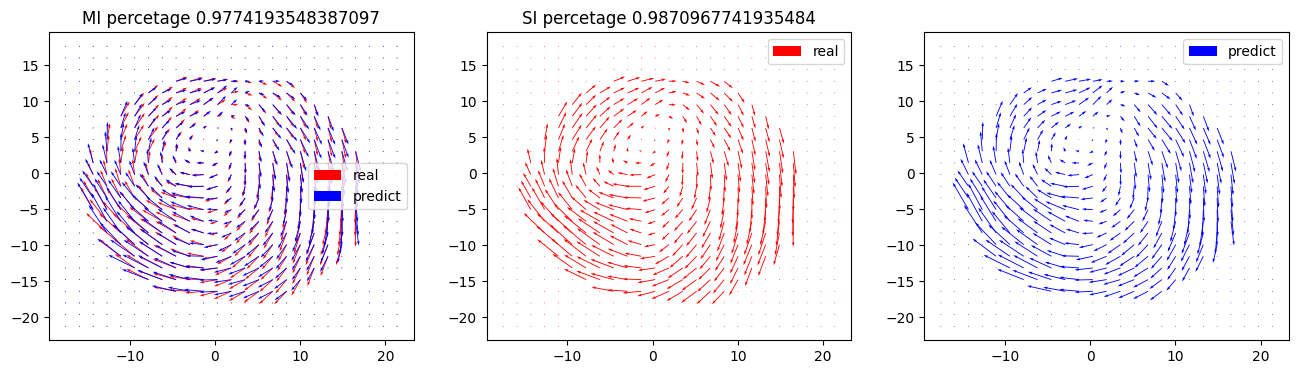

1
MI(average/percent):
0.9412053594946833 0.9806451612903225
SI(average/percent):
0.9868730208011156 0.9935483870967742
2
MI(average/percent):
0.9450149815200536 0.9838709677419355
SI(average/percent):
0.9887791289160219 0.9967741935483871
3
MI(average/percent):
0.9465875823010755 0.9935483870967742
SI(average/percent):
0.9900024507160902 0.9967741935483871
4
MI(average/percent):
0.945389814853259 0.9935483870967742
SI(average/percent):
0.9904983467518013 0.9967741935483871
5
MI(average/percent):
0.9424912588488982 0.9935483870967742
SI(average/percent):
0.990344731038067 0.9967741935483871


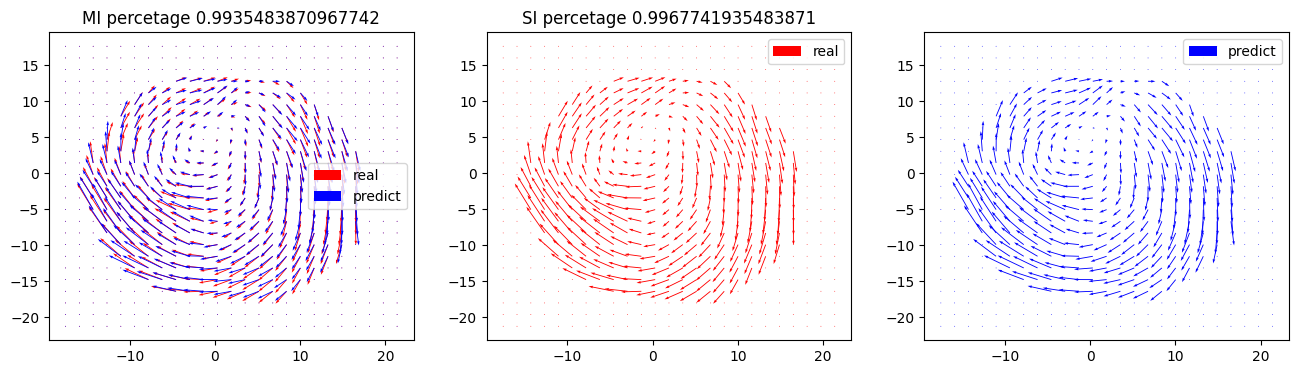

6
MI(average/percent):
0.9450134440679447 0.9935483870967742
SI(average/percent):
0.9892916875859877 0.9935483870967742
7
MI(average/percent):
0.946058884838293 0.9870967741935484
SI(average/percent):
0.9874231416166175 0.9967741935483871
8
MI(average/percent):
0.9454721602872962 0.9741935483870968
SI(average/percent):
0.9848064530441338 0.9935483870967742
9
MI(average/percent):
0.9427804717930958 0.967741935483871
SI(average/percent):
0.9814964529000327 0.9870967741935484
10
MI(average/percent):
0.9378919015645746 0.9612903225806452
SI(average/percent):
0.9775280441976028 0.9774193548387097


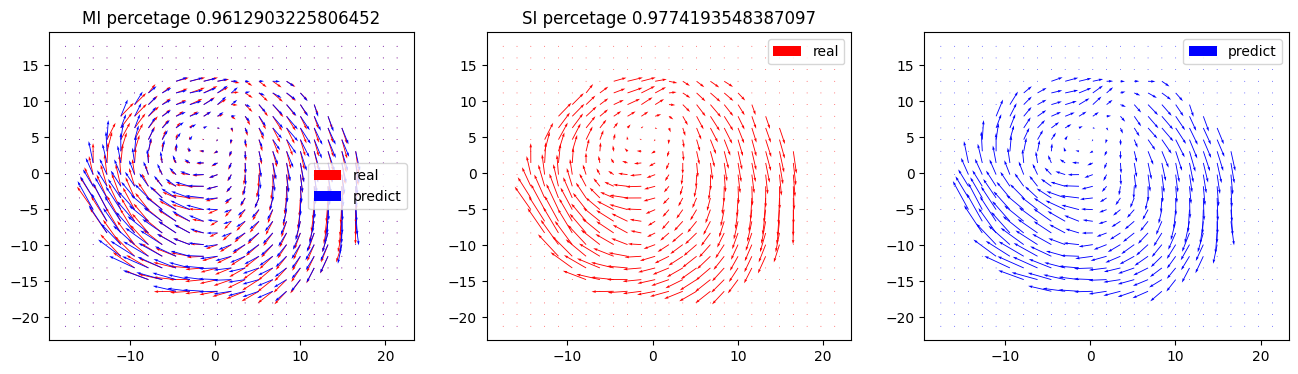

11
MI(average/percent):
0.9400711512713353 0.9741935483870968
SI(average/percent):
0.9794525856138582 0.9806451612903225
12
MI(average/percent):
0.9412077194216558 0.9774193548387097
SI(average/percent):
0.9808603258111761 0.9838709677419355
13
MI(average/percent):
0.9416574062077527 0.9774193548387097
SI(average/percent):
0.9817704621690054 0.9806451612903225
14
MI(average/percent):
0.9415186289608964 0.9774193548387097
SI(average/percent):
0.9822000147087449 0.9870967741935484
15
MI(average/percent):
0.9402580382163372 0.9774193548387097
SI(average/percent):
0.9821550444947685 0.9903225806451613


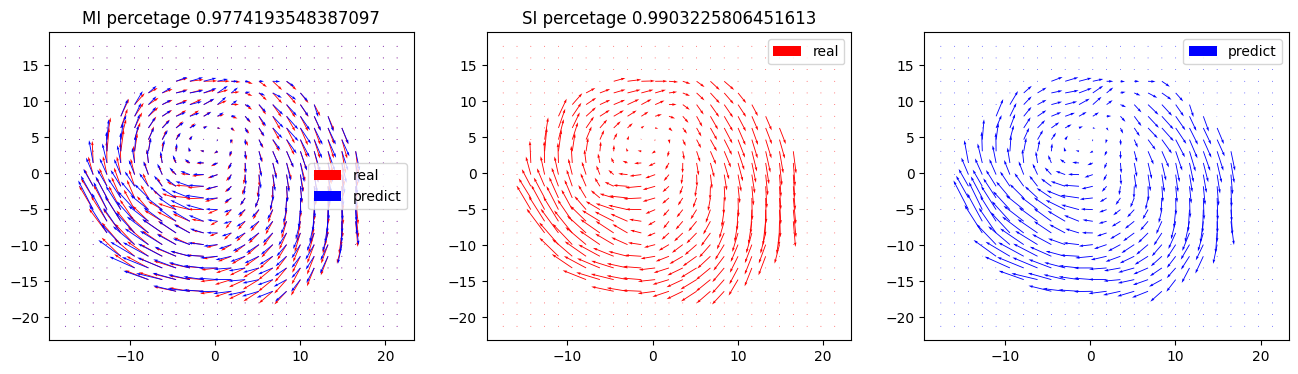

16
MI(average/percent):
0.9428354690613314 0.9774193548387097
SI(average/percent):
0.9827491116618726 0.9935483870967742
17
MI(average/percent):
0.9447045338425519 0.9806451612903225
SI(average/percent):
0.9826705358594499 0.9935483870967742
18
MI(average/percent):
0.9455577640178896 0.9838709677419355
SI(average/percent):
0.9818656921727205 0.9935483870967742
19
MI(average/percent):
0.9449183313433925 0.9838709677419355
SI(average/percent):
0.9804016549056864 0.9903225806451613
20
MI(average/percent):
0.9420588938978742 0.9838709677419355
SI(average/percent):
0.9783611007278629 0.9903225806451613


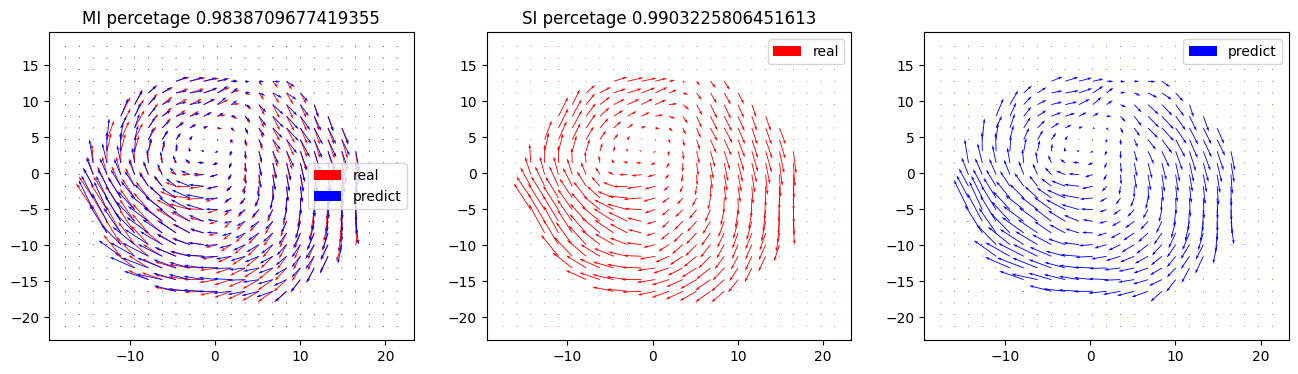

21
MI(average/percent):
0.944860123414161 0.9838709677419355
SI(average/percent):
0.9797202996747396 0.9903225806451613
22
MI(average/percent):
0.9453446932655974 0.9870967741935484
SI(average/percent):
0.98026997268616 0.9935483870967742
23
MI(average/percent):
0.943180498480093 0.9806451612903225
SI(average/percent):
0.9800598808493486 0.9967741935483871
24
MI(average/percent):
0.9393492826275192 0.9741935483870968
SI(average/percent):
0.9791217381685485 0.9967741935483871
25
MI(average/percent):
0.9345903571795277 0.9709677419354839
SI(average/percent):
0.9774776472964104 0.9935483870967742


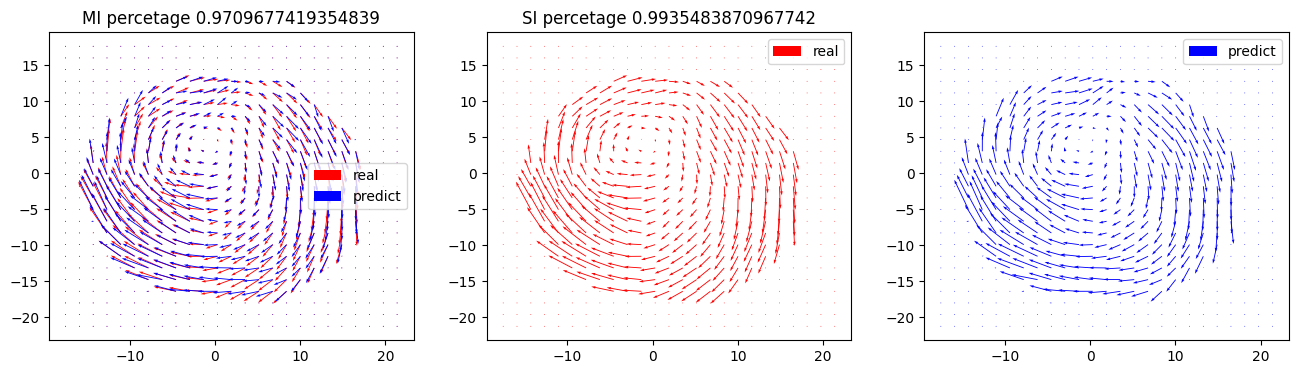

26
MI(average/percent):
0.9379282765840842 0.9709677419354839
SI(average/percent):
0.9793221449906429 0.9935483870967742
27
MI(average/percent):
0.9399604377002699 0.9709677419354839
SI(average/percent):
0.9806088742601153 0.9903225806451613
28
MI(average/percent):
0.9404232588218944 0.9709677419354839
SI(average/percent):
0.9813360538964128 0.9903225806451613
29
MI(average/percent):
0.9393201207532748 0.9709677419354839
SI(average/percent):
0.9814979310350531 0.9903225806451613
30
MI(average/percent):
0.936512074638545 0.967741935483871
SI(average/percent):
0.9810846192327978 0.9903225806451613


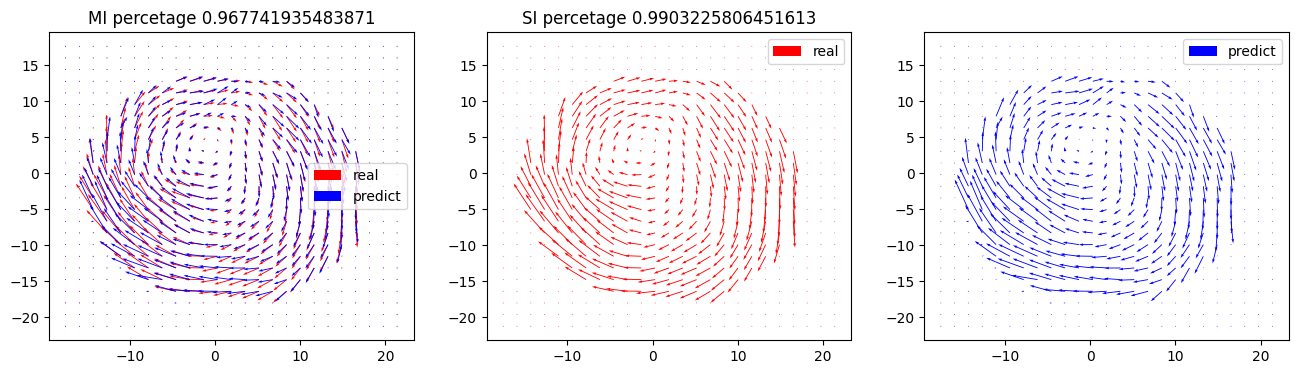

31
MI(average/percent):
0.9388806149839902 0.9741935483870968
SI(average/percent):
0.9827781252882415 0.9903225806451613
32
MI(average/percent):
0.9389545158434175 0.9806451612903225
SI(average/percent):
0.9838255618831805 0.9903225806451613
33
MI(average/percent):
0.9369964163093757 0.9806451612903225
SI(average/percent):
0.9842185989666224 0.9935483870967742
34
MI(average/percent):
0.9334531392714481 0.9709677419354839
SI(average/percent):
0.9839198256107686 0.9935483870967742
35
MI(average/percent):
0.9291240403877017 0.964516129032258
SI(average/percent):
0.9828660184945002 0.9935483870967742


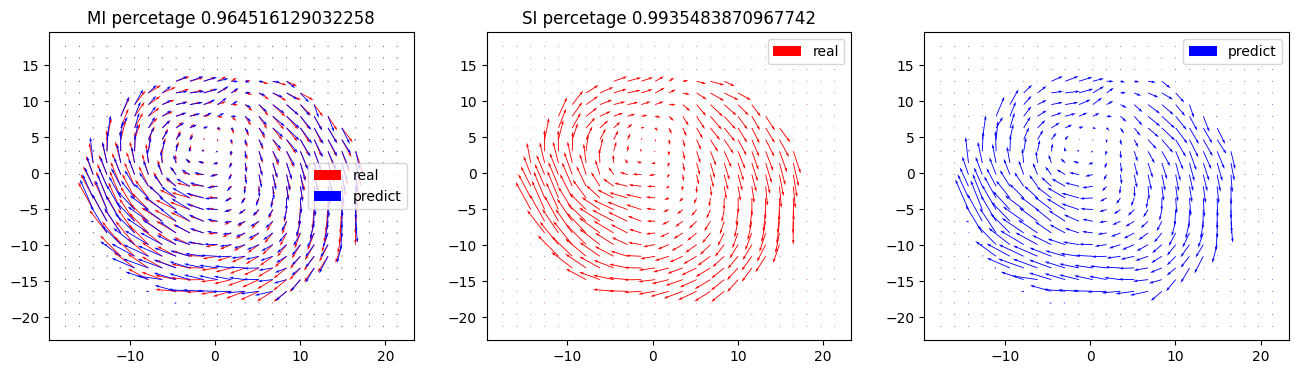

36
MI(average/percent):
0.9309960815724478 0.9580645161290322
SI(average/percent):
0.9827874739820877 0.9967741935483871
37
MI(average/percent):
0.9305216430597248 0.964516129032258
SI(average/percent):
0.9815651848396765 0.9967741935483871
38
MI(average/percent):
0.9285755136336367 0.9451612903225807
SI(average/percent):
0.9790402293736494 0.9903225806451613
39
MI(average/percent):
0.9255299472240447 0.9387096774193548
SI(average/percent):
0.975511556640736 0.9870967741935484
40
MI(average/percent):
0.921372957528745 0.932258064516129
SI(average/percent):
0.9733262847980931 0.9838709677419355


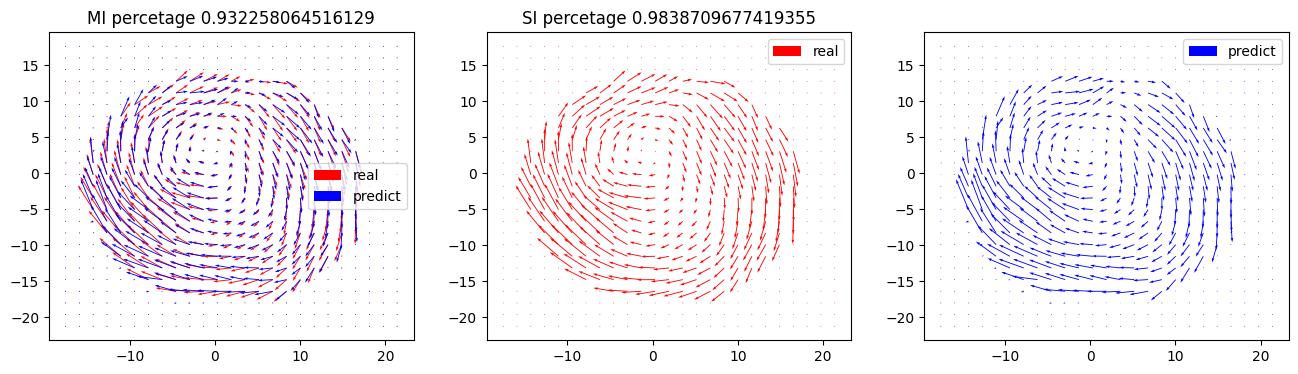

41
MI(average/percent):
0.9205323061293651 0.9161290322580645
SI(average/percent):
0.9735566579173115 0.9870967741935484
42
MI(average/percent):
0.9185001035536469 0.9161290322580645
SI(average/percent):
0.9742381826799772 0.9838709677419355
43
MI(average/percent):
0.9147993777361167 0.9
SI(average/percent):
0.9735837331179352 0.9870967741935484
44
MI(average/percent):
0.9098523448665721 0.8870967741935484
SI(average/percent):
0.9739561689798545 0.9838709677419355
45
MI(average/percent):
0.9050402079521549 0.8903225806451613
SI(average/percent):
0.9740467463377813 0.9838709677419355


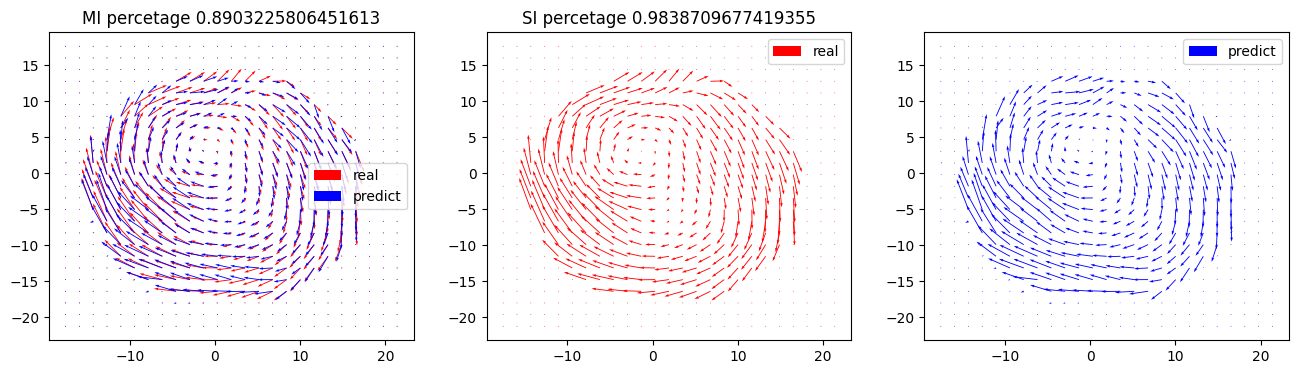

46
MI(average/percent):
0.9045228863312621 0.8741935483870967
SI(average/percent):
0.9751503622557507 0.9838709677419355
47
MI(average/percent):
0.9033659097028361 0.8806451612903226
SI(average/percent):
0.9751927437450335 0.9838709677419355
48
MI(average/percent):
0.9014555071779008 0.8838709677419355
SI(average/percent):
0.9743686476236048 0.9838709677419355
49
MI(average/percent):
0.8980784433182135 0.867741935483871
SI(average/percent):
0.972898239527358 0.9838709677419355
50
MI(average/percent):
0.8937236109951107 0.8612903225806452
SI(average/percent):
0.9714945918133829 0.9838709677419355


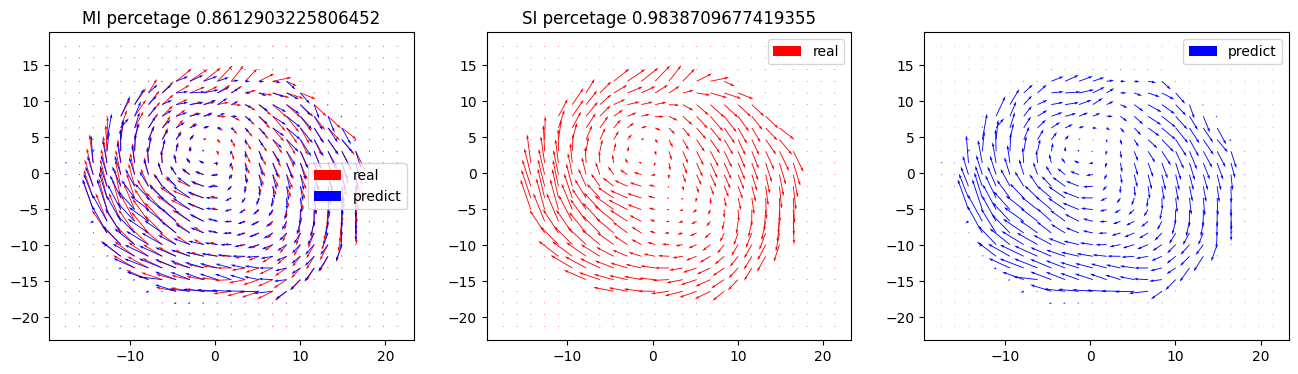

51
MI(average/percent):
0.8967880964572501 0.867741935483871
SI(average/percent):
0.9720608590129797 0.9838709677419355
52
MI(average/percent):
0.8988645804042749 0.864516129032258
SI(average/percent):
0.9719688083145702 0.9806451612903225
53
MI(average/percent):
0.899763483723638 0.8580645161290322
SI(average/percent):
0.9712279138037383 0.9774193548387097
54
MI(average/percent):
0.8997713439612204 0.8580645161290322
SI(average/percent):
0.9698164005621333 0.9741935483870968
55
MI(average/percent):
0.8990717001604397 0.8580645161290322
SI(average/percent):
0.9676825871114869 0.9709677419354839


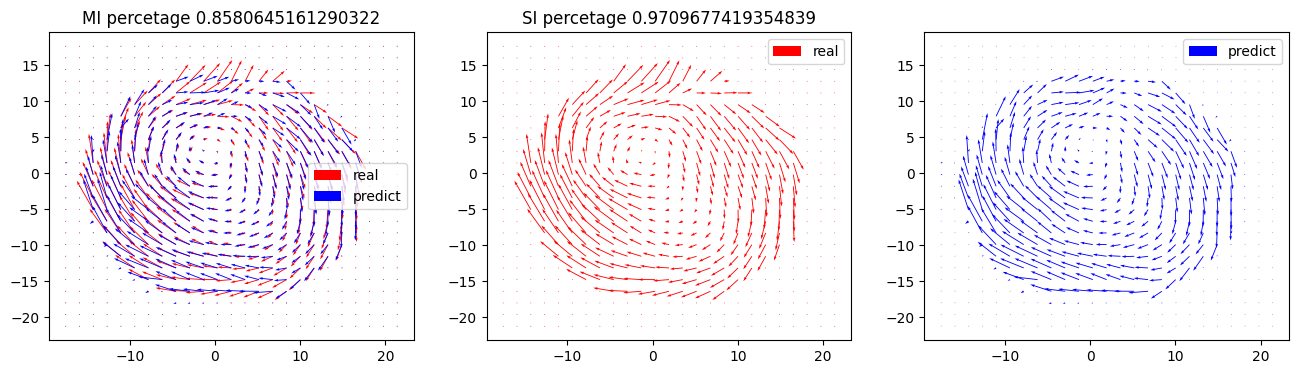

56
MI(average/percent):
0.8995545512820626 0.864516129032258
SI(average/percent):
0.9672725716445593 0.9709677419354839
57
MI(average/percent):
0.8991481123466099 0.8709677419354839
SI(average/percent):
0.9662019698839188 0.967741935483871
58
MI(average/percent):
0.8980914543439328 0.864516129032258
SI(average/percent):
0.9644670163736698 0.967741935483871
59
MI(average/percent):
0.896086085873689 0.8741935483870967
SI(average/percent):
0.9624567068875626 0.9548387096774194
60
MI(average/percent):
0.8933622243164195 0.8709677419354839
SI(average/percent):
0.9601323208017597 0.9516129032258065


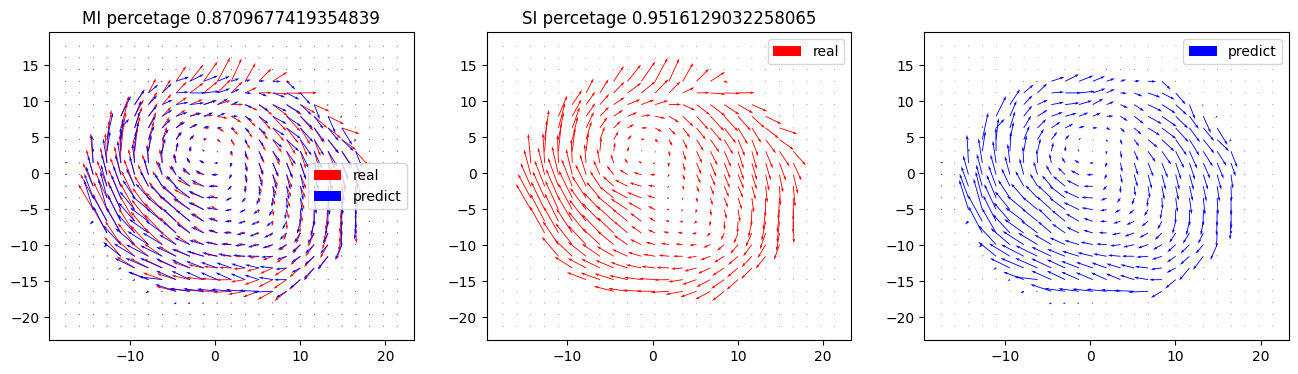

61
MI(average/percent):
0.8939679693736832 0.8806451612903226
SI(average/percent):
0.9614536400887522 0.9580645161290322
62
MI(average/percent):
0.8940631874079278 0.8741935483870967
SI(average/percent):
0.9626379589770284 0.9709677419354839
63
MI(average/percent):
0.893514437216288 0.8806451612903226
SI(average/percent):
0.9633588865577958 0.9709677419354839
64
MI(average/percent):
0.8925664889327272 0.8774193548387097
SI(average/percent):
0.9629368676154522 0.9741935483870968
65
MI(average/percent):
0.8913160230567633 0.8709677419354839
SI(average/percent):
0.961371343035961 0.9741935483870968


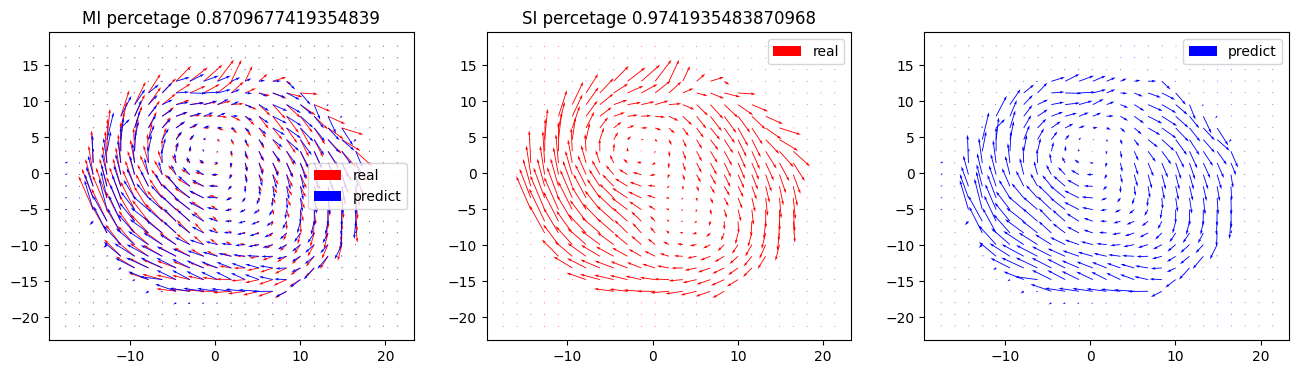

66
MI(average/percent):
0.8897745849347801 0.867741935483871
SI(average/percent):
0.959794793749735 0.9612903225806452
67
MI(average/percent):
0.8879269100556747 0.8709677419354839
SI(average/percent):
0.9575658076393972 0.967741935483871
68
MI(average/percent):
0.8858652152444421 0.8612903225806452
SI(average/percent):
0.9545848339706265 0.9516129032258065
69
MI(average/percent):
0.8832638872643309 0.8516129032258064
SI(average/percent):
0.951101543085154 0.9354838709677419
70
MI(average/percent):
0.8799943361575511 0.8548387096774194
SI(average/percent):
0.9464958813755742 0.9258064516129032


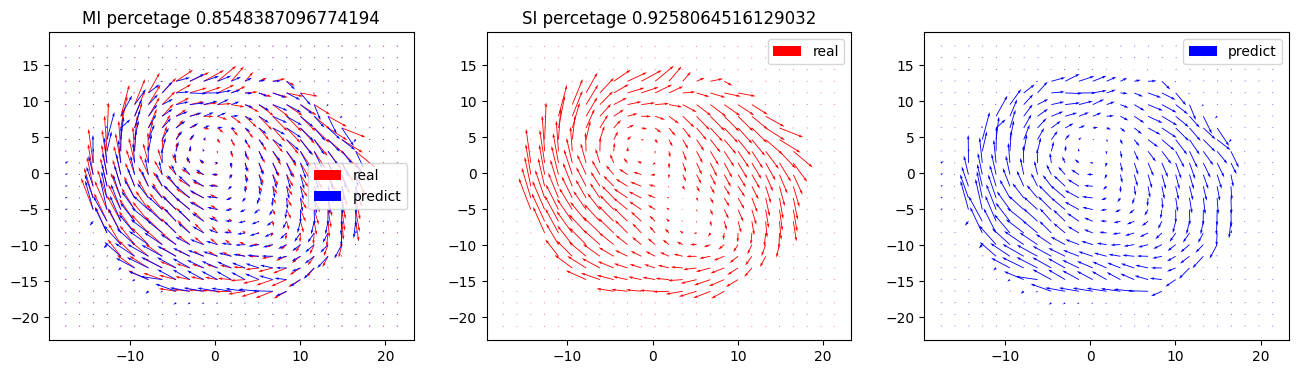

71
MI(average/percent):
0.8809495481144703 0.8548387096774194
SI(average/percent):
0.9428723403357447 0.9193548387096774
72
MI(average/percent):
0.8817962739834049 0.8516129032258064
SI(average/percent):
0.9368258678803615 0.9161290322580645
73
MI(average/percent):
0.882982116289824 0.8548387096774194
SI(average/percent):
0.9307379162032312 0.9129032258064517
74
MI(average/percent):
0.8844608027153211 0.8548387096774194
SI(average/percent):
0.9280592279333206 0.9096774193548387
75
MI(average/percent):
0.8855133300315597 0.8612903225806452
SI(average/percent):
0.9237142321824432 0.8935483870967742


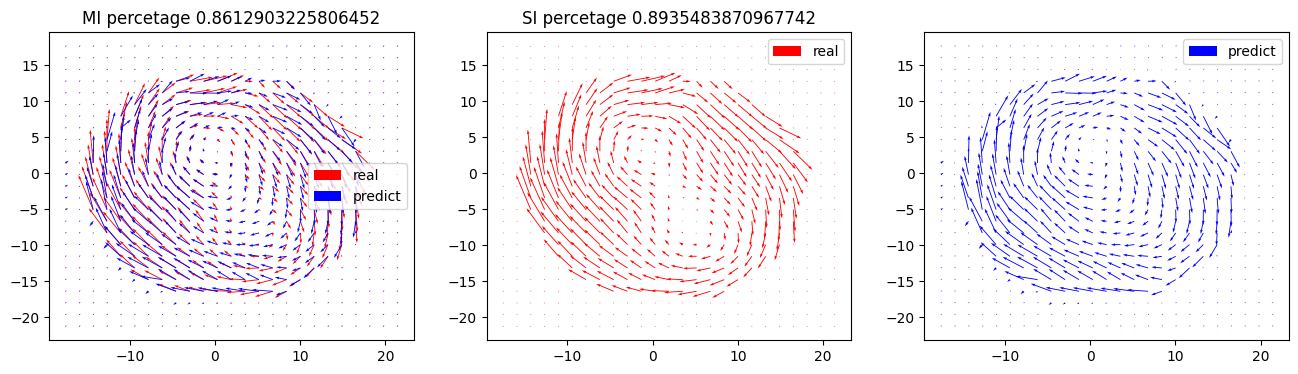

76
MI(average/percent):
0.8857063720452417 0.8580645161290322
SI(average/percent):
0.9236903009978319 0.9
77
MI(average/percent):
0.8856564672064433 0.8483870967741935
SI(average/percent):
0.9235620431340843 0.9
78
MI(average/percent):
0.8855323100568263 0.8387096774193549
SI(average/percent):
0.9226859127768849 0.9
79
MI(average/percent):
0.8847338233600045 0.8387096774193549
SI(average/percent):
0.9207214120473547 0.9
80
MI(average/percent):
0.8836398296158016 0.8387096774193549
SI(average/percent):
0.9190513810434954 0.9032258064516129


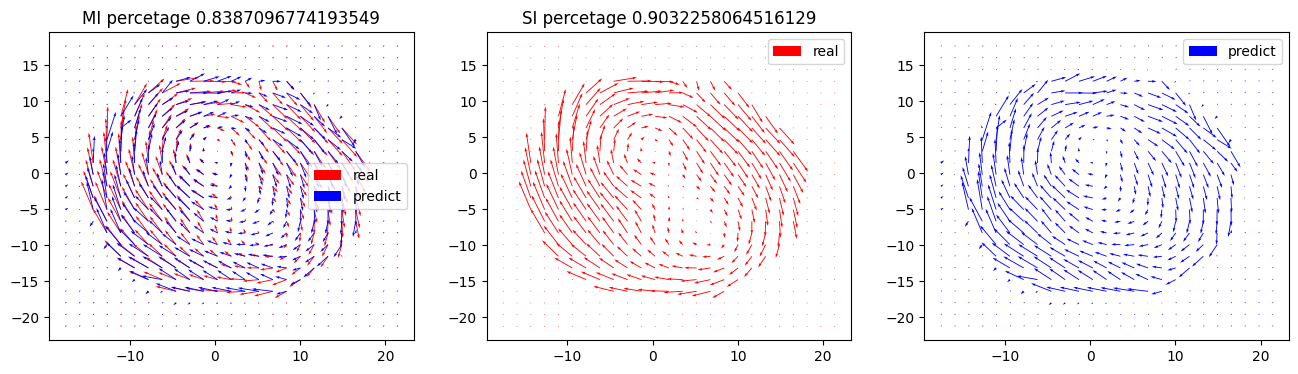

81
MI(average/percent):
0.8849462889667334 0.832258064516129
SI(average/percent):
0.9173861184834612 0.8935483870967742
82
MI(average/percent):
0.8860293416385441 0.8419354838709677
SI(average/percent):
0.9165190778688852 0.9
83
MI(average/percent):
0.8871550268486645 0.8354838709677419
SI(average/percent):
0.913725046579137 0.9032258064516129
84
MI(average/percent):
0.8878943402616395 0.8483870967741935
SI(average/percent):
0.9101023004242025 0.8870967741935484
85
MI(average/percent):
0.8882331160357289 0.8483870967741935
SI(average/percent):
0.9069177753084503 0.8806451612903226


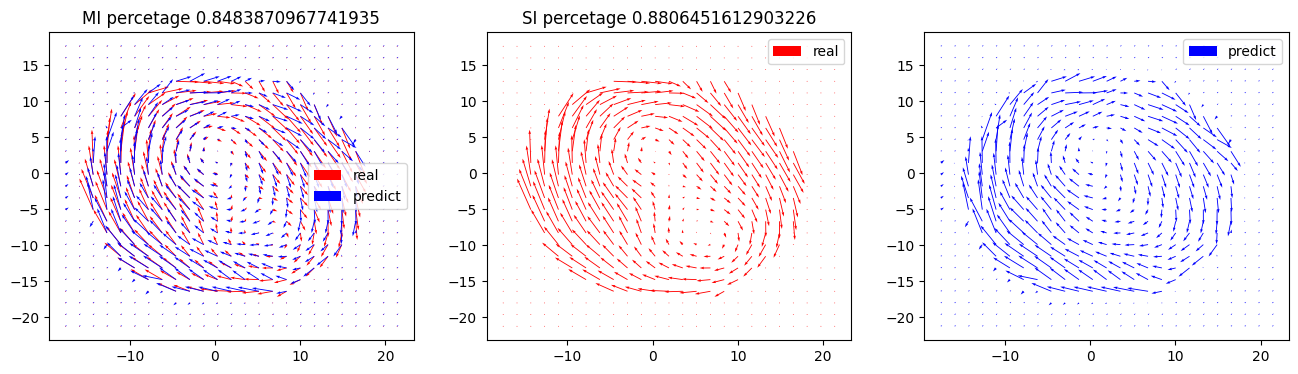

86
MI(average/percent):
0.8930974429898358 0.864516129032258
SI(average/percent):
0.9045038160980885 0.8774193548387097
87
MI(average/percent):
0.897290318237171 0.867741935483871
SI(average/percent):
0.9035074582385902 0.8741935483870967
88
MI(average/percent):
0.9005217097496591 0.8806451612903226
SI(average/percent):
0.9046127237136441 0.864516129032258
89
MI(average/percent):
0.9029909037387549 0.8870967741935484
SI(average/percent):
0.9041298525831354 0.8709677419354839
90
MI(average/percent):
0.9044279869478581 0.8903225806451613
SI(average/percent):
0.9021335430305005 0.8612903225806452


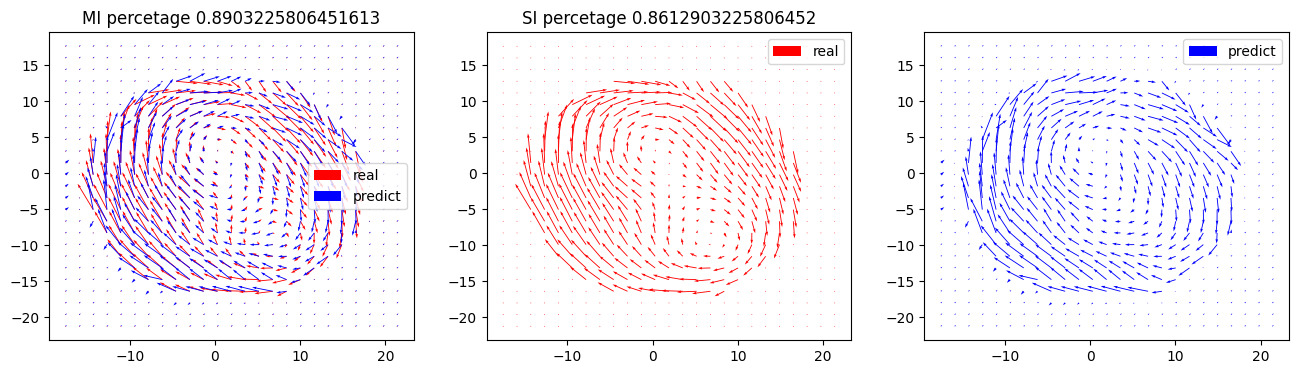

91
MI(average/percent):
0.9042646219318005 0.8935483870967742
SI(average/percent):
0.9007965627753072 0.8548387096774194
92
MI(average/percent):
0.9030363227647397 0.8774193548387097
SI(average/percent):
0.8984629797445778 0.8516129032258064
93
MI(average/percent):
0.9012477305953907 0.8741935483870967
SI(average/percent):
0.8963299528397949 0.8548387096774194
94
MI(average/percent):
0.8982909302299521 0.8709677419354839
SI(average/percent):
0.8934577077072813 0.8483870967741935
95
MI(average/percent):
0.894649233561855 0.864516129032258
SI(average/percent):
0.8896916177704055 0.8354838709677419


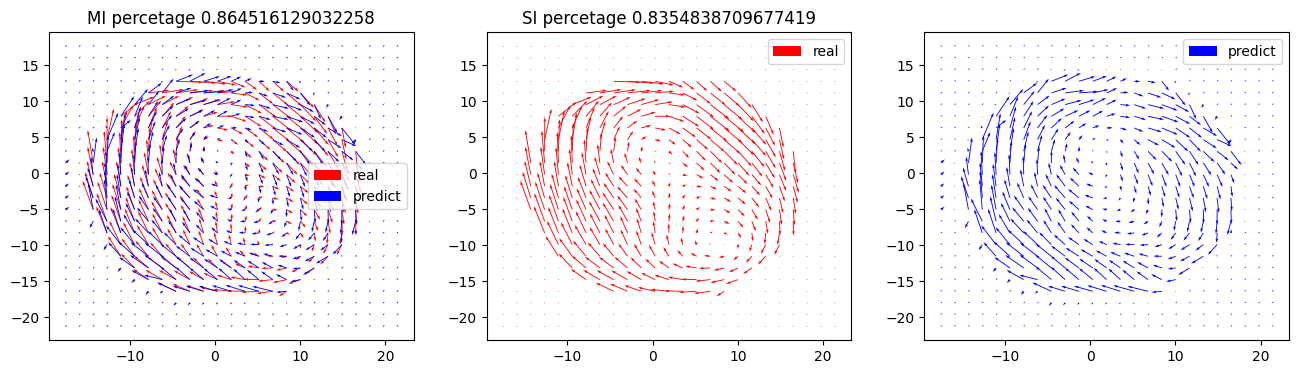

96
MI(average/percent):
0.8971964918598633 0.8774193548387097
SI(average/percent):
0.8899681273402967 0.8354838709677419
97
MI(average/percent):
0.8989150204260132 0.8741935483870967
SI(average/percent):
0.8891343040232411 0.8354838709677419
98
MI(average/percent):
0.8996085076789696 0.8483870967741935
SI(average/percent):
0.8876990350189723 0.8387096774193549
99
MI(average/percent):
0.8987501838831938 0.8451612903225807
SI(average/percent):
0.8859004373301781 0.8258064516129032
100
MI(average/percent):
0.896986394641618 0.8419354838709677
SI(average/percent):
0.8838870563002004 0.8161290322580645


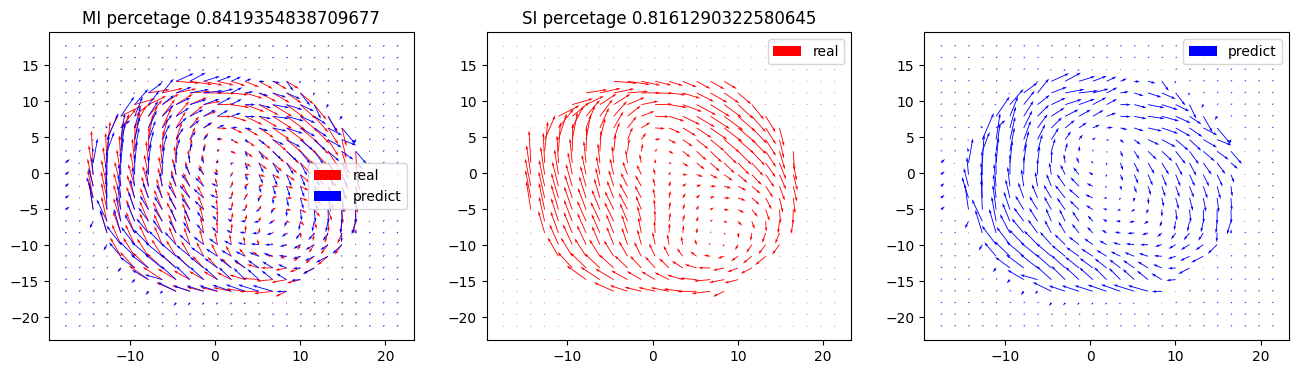

101
MI(average/percent):
0.8969013007753976 0.8419354838709677
SI(average/percent):
0.8859567171621436 0.8225806451612904
102
MI(average/percent):
0.8959404404599097 0.8419354838709677
SI(average/percent):
0.8876017643372421 0.8258064516129032
103
MI(average/percent):
0.8943668759523753 0.8451612903225807
SI(average/percent):
0.8887101193614718 0.832258064516129
104
MI(average/percent):
0.8924676272509058 0.8451612903225807
SI(average/percent):
0.8893091448879547 0.832258064516129
105
MI(average/percent):
0.8900549820108685 0.8451612903225807
SI(average/percent):
0.8895572957713468 0.8290322580645161


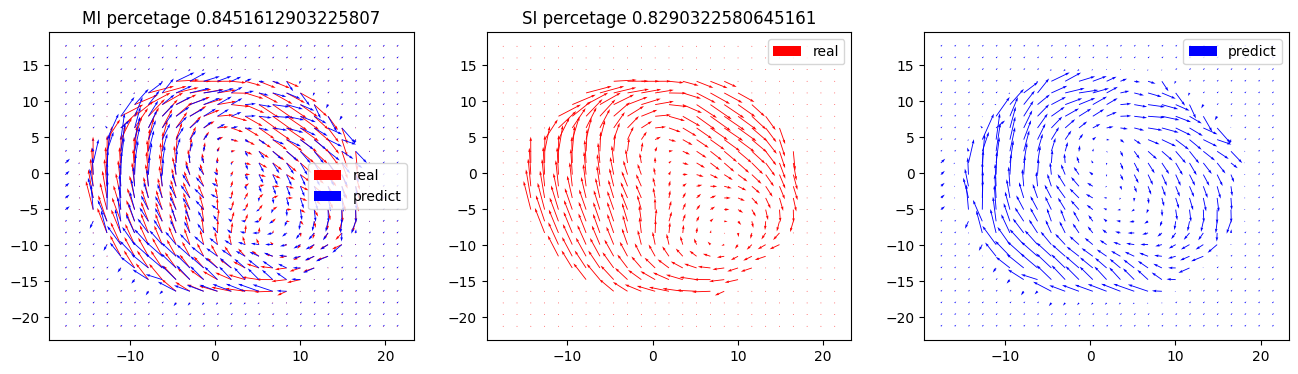

106
MI(average/percent):
0.8893594519965928 0.8419354838709677
SI(average/percent):
0.888768655928921 0.832258064516129
107
MI(average/percent):
0.88802649206462 0.8483870967741935
SI(average/percent):
0.8876455092941274 0.8354838709677419
108
MI(average/percent):
0.8864545843322024 0.8354838709677419
SI(average/percent):
0.8861832422037226 0.8290322580645161
109
MI(average/percent):
0.8847201861770051 0.8387096774193549
SI(average/percent):
0.8843906555458111 0.8290322580645161
110
MI(average/percent):
0.8825248409057752 0.832258064516129
SI(average/percent):
0.8823019545371357 0.8225806451612904


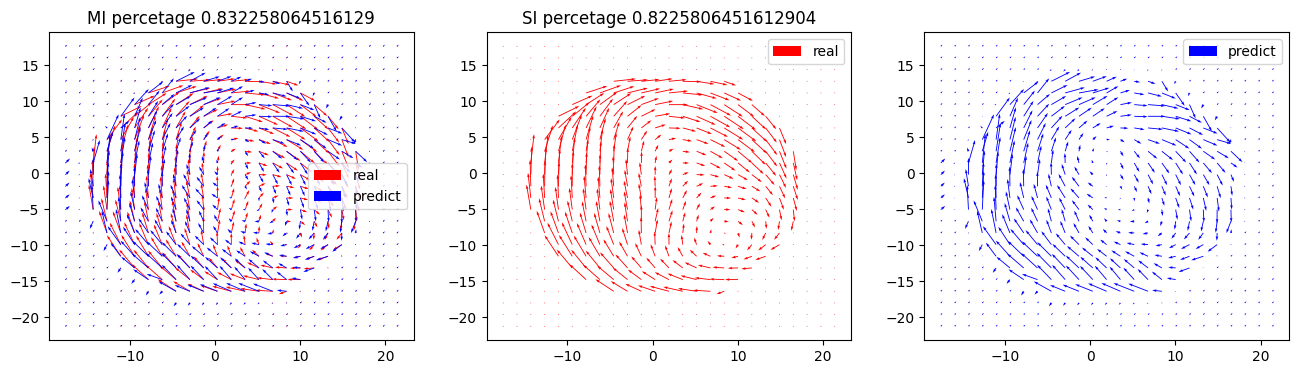

111
MI(average/percent):
0.8803082380823524 0.832258064516129
SI(average/percent):
0.882884834452367 0.8225806451612904
112
MI(average/percent):
0.8779966080348913 0.832258064516129
SI(average/percent):
0.8833363984220358 0.832258064516129
113
MI(average/percent):
0.8758317214802406 0.8161290322580645
SI(average/percent):
0.8833055172131387 0.832258064516129
114
MI(average/percent):
0.8737807994386901 0.8161290322580645
SI(average/percent):
0.8826473060374895 0.8258064516129032
115
MI(average/percent):
0.8717835423321323 0.8193548387096774
SI(average/percent):
0.8810888674577269 0.8225806451612904


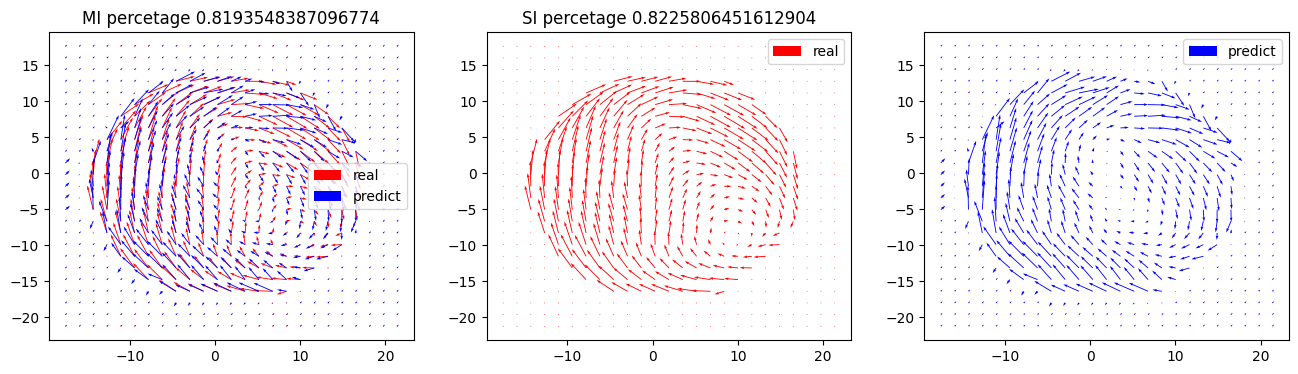

116
MI(average/percent):
0.8723030005451518 0.8258064516129032
SI(average/percent):
0.8786555400556113 0.8225806451612904
117
MI(average/percent):
0.8725650671956499 0.8290322580645161
SI(average/percent):
0.8783054047470388 0.8258064516129032
118
MI(average/percent):
0.8728576431258053 0.8354838709677419
SI(average/percent):
0.8786101471880822 0.8193548387096774
119
MI(average/percent):
0.8727372006648951 0.8419354838709677
SI(average/percent):
0.877625888418729 0.8258064516129032
120
MI(average/percent):
0.8724042821308847 0.8354838709677419
SI(average/percent):
0.8770884966495907 0.8387096774193549


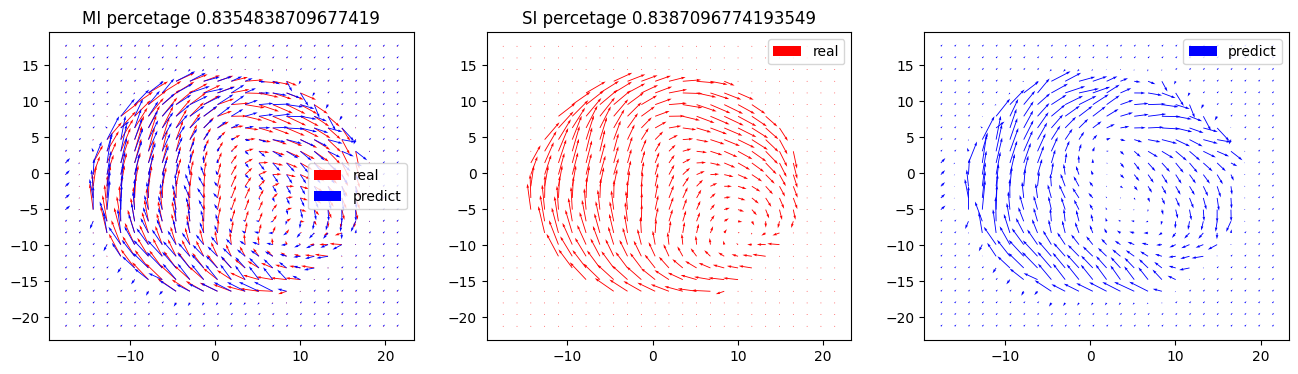

121
MI(average/percent):
0.8724757011387485 0.8258064516129032
SI(average/percent):
0.8787238873294901 0.8387096774193549
122
MI(average/percent):
0.8723718477307814 0.832258064516129
SI(average/percent):
0.8810508983385742 0.8290322580645161
123
MI(average/percent):
0.8718900712117134 0.8193548387096774
SI(average/percent):
0.8837167712207672 0.8225806451612904
124
MI(average/percent):
0.8706724206578157 0.8129032258064516
SI(average/percent):
0.8854602429740814 0.8258064516129032
125
MI(average/percent):
0.8692668091175889 0.8064516129032258
SI(average/percent):
0.8862078176504211 0.8193548387096774


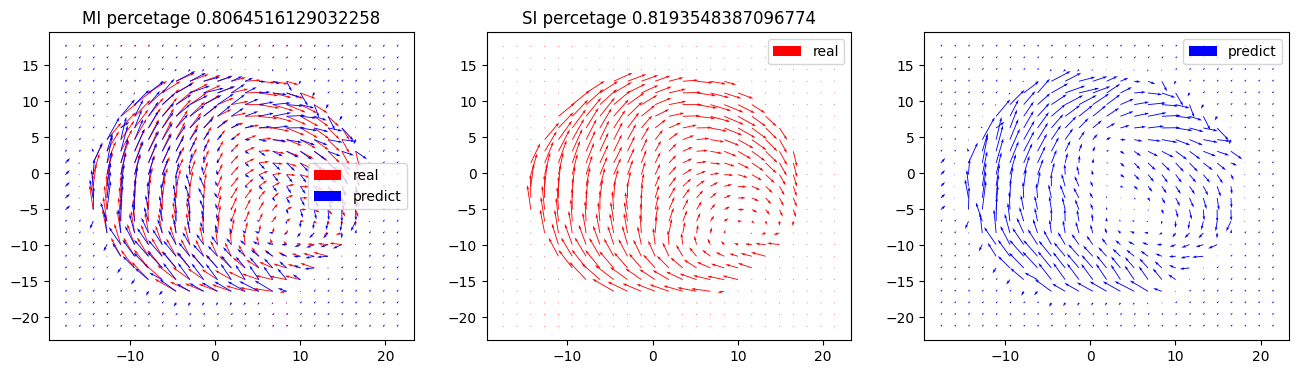

126
MI(average/percent):
0.8707157557891687 0.8032258064516129
SI(average/percent):
0.8876982330582964 0.8258064516129032
127
MI(average/percent):
0.8717683460576015 0.8161290322580645
SI(average/percent):
0.8895423040246591 0.8290322580645161
128
MI(average/percent):
0.8723699153486721 0.8193548387096774
SI(average/percent):
0.8910830777918043 0.832258064516129
129
MI(average/percent):
0.87288403770615 0.8290322580645161
SI(average/percent):
0.8938968396341768 0.832258064516129
130
MI(average/percent):
0.873432884659032 0.8225806451612904
SI(average/percent):
0.8962080329137286 0.8290322580645161


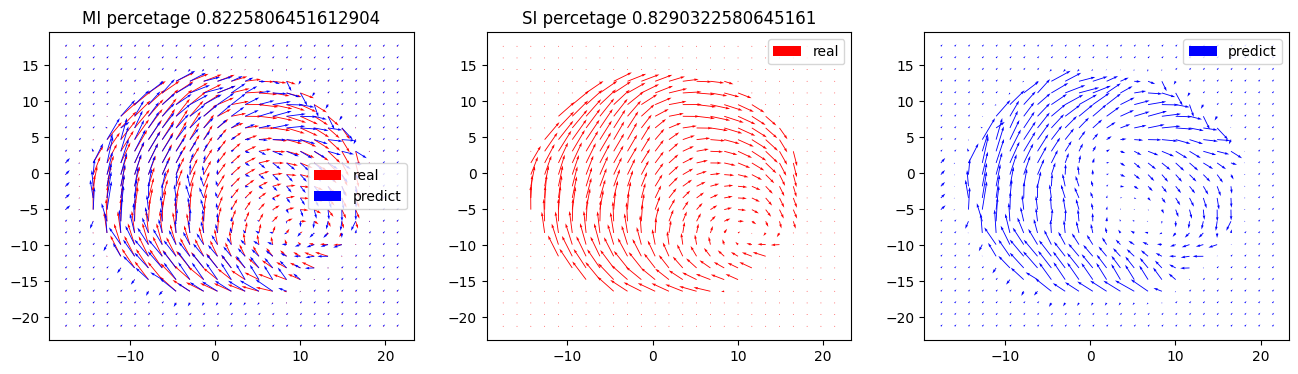

131
MI(average/percent):
0.8720209788758744 0.8225806451612904
SI(average/percent):
0.8972206296600549 0.8387096774193549
132
MI(average/percent):
0.8704397584697285 0.8258064516129032
SI(average/percent):
0.8979877542025558 0.8451612903225807
133
MI(average/percent):
0.8684759088969444 0.8161290322580645
SI(average/percent):
0.8998487090054317 0.8483870967741935
134
MI(average/percent):
0.8662693638292596 0.8129032258064516
SI(average/percent):
0.9011150237582454 0.8419354838709677
135
MI(average/percent):
0.8641826374172449 0.8032258064516129
SI(average/percent):
0.9027539618710869 0.8419354838709677


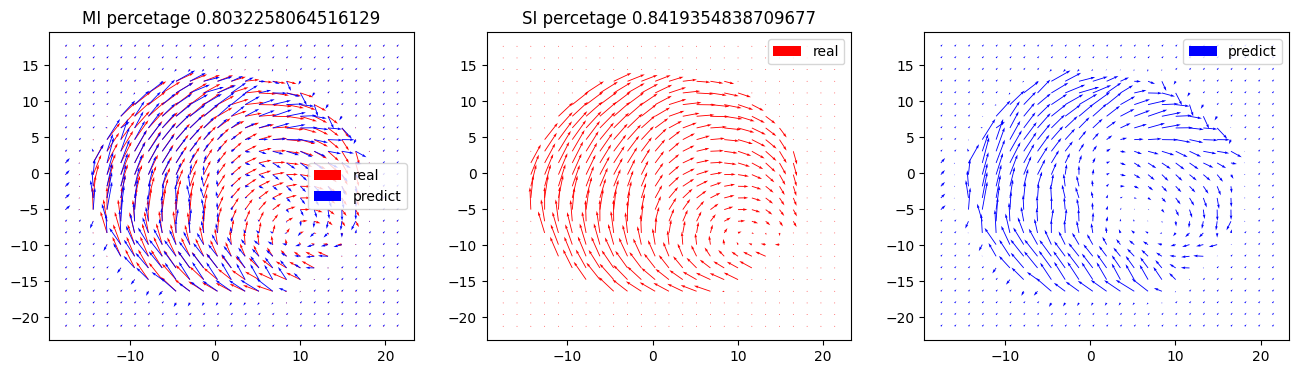

136
MI(average/percent):
0.8651614482528293 0.8032258064516129
SI(average/percent):
0.9057162490268893 0.8451612903225807
137
MI(average/percent):
0.8658724238313975 0.8064516129032258
SI(average/percent):
0.9082415264843963 0.8451612903225807
138
MI(average/percent):
0.8663640926671806 0.8064516129032258
SI(average/percent):
0.9103392831722124 0.8580645161290322
139
MI(average/percent):
0.8668390650176369 0.8064516129032258
SI(average/percent):
0.9125794642191813 0.8612903225806452
140
MI(average/percent):
0.8670797539937933 0.8096774193548387
SI(average/percent):
0.9149455476972764 0.8612903225806452


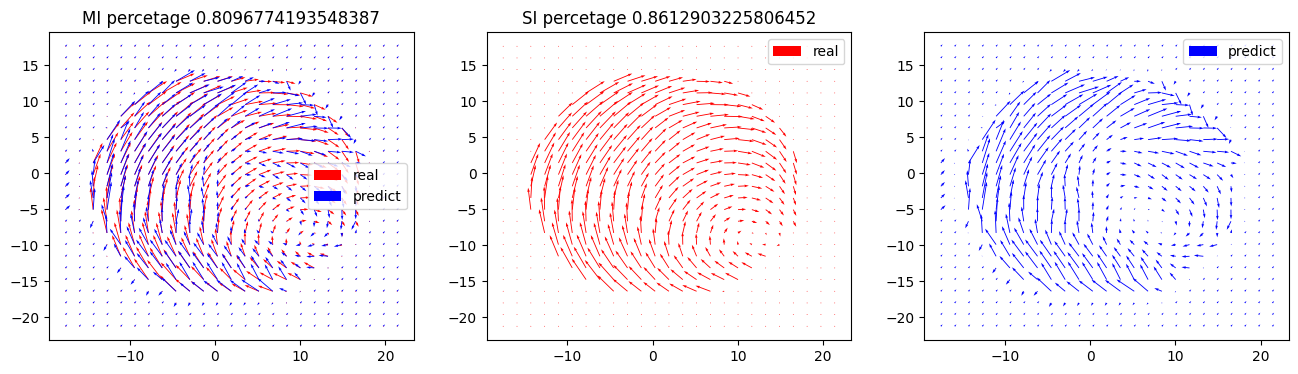

141
MI(average/percent):
0.8666829593353992 0.8096774193548387
SI(average/percent):
0.9163953192224996 0.864516129032258
142
MI(average/percent):
0.8662143328648063 0.8064516129032258
SI(average/percent):
0.9172259074540972 0.8741935483870967
143
MI(average/percent):
0.8658498235603677 0.8
SI(average/percent):
0.9178306492738175 0.8774193548387097
144
MI(average/percent):
0.8654684615409096 0.7870967741935484
SI(average/percent):
0.9190208999299693 0.8806451612903226
145
MI(average/percent):
0.8649214899098648 0.7838709677419354
SI(average/percent):
0.917749556102027 0.8870967741935484


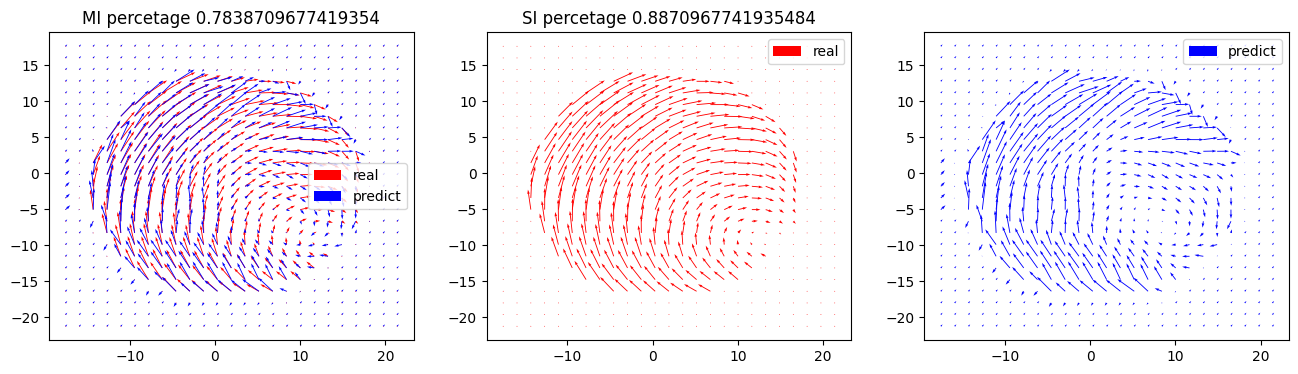

In [13]:
for i in range(p_tot):
    print(i)
    j=i
    mi_t[i],mi_t_per[i]=miscore(pltpredict[:,:,j,],v_test[:,:,j,:])
    si_t[i],si_t_per[i]=siscore(pltpredict[:,:,j,],v_test[:,:,j,:])
    if i%(addp)==0:
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 3, 1)
        plt.title('MI percetage '+str(mi_t_per[i]))
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
        plt.legend()
        plt.subplot(1, 3, 2)
        plt.title('SI percetage '+str(si_t_per[i]))
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
        #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
        plt.legend()
        plt.subplot(1, 3, 3)
        #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
        plt.legend()
        plt.show()
    

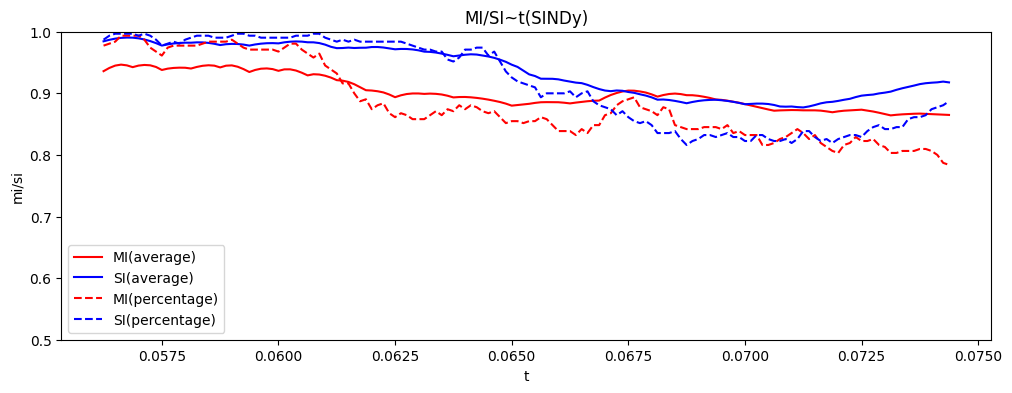

In [14]:
plt.figure(figsize=(12, 4))
plt.title('MI/SI~t(SINDy)')
plt.ylim(0,1)
plt.xlabel('t')
plt.ylabel('mi/si')
plt.plot(t_train,mi_t,'r',label='MI(average)')
plt.plot(t_train,si_t,'b',label='SI(average)')
plt.plot(t_train,mi_t_per,'r--',label='MI(percentage)')
plt.plot(t_train,si_t_per,'b--',label='SI(percentage)')
plt.legend()
plt.ylim(0.5, 1)
plt.plot
plt.show()